In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import string
import nltk
import spacy
from gensim import corpora
from gensim.models import LdaModel, Phrases, TfidfModel
from gensim.models.phrases import Phraser
from nltk import SnowballStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from tqdm import tqdm

from wordcloud import WordCloud

import matplotlib.colors as mcolors

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

nltk.download('punkt')
# !python3 -m spacy download en

[nltk_data] Downloading package punkt to /Users/marcus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [41]:
grey = (187/255, 187/255, 187/255)
darkgreen = (51/255, 117/255, 56/255)
teal = (93/255, 168/255, 153/255)
blue = (148/255, 203/255, 236/255)
yellow = (220/255, 205/255, 125/255)

color_pallete = sns.color_palette([grey, darkgreen, teal, blue, yellow])

# Feedback Analysis

In [42]:
feedback_df = pd.read_csv('../Menagerie/data/grades.csv', index_col=0)
feedback_df = feedback_df[~feedback_df['grade'].isnull()]
feedback_df

,assignment_number,comments,skill,participant_id,batch,grade
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-
...,...,...,...,...,...,...
15,58.0,NaN,Documentation,14,1,A++
16,353.0,NaN,Documentation,14,1,A++
17,422.0,NaN,Documentation,14,1,A++
18,480.0,NaN,Documentation,14,1,A++


## Summary Analysis
### Count of submissions with no feedback

In [43]:
count_df = feedback_df.groupby('skill').count().reset_index()
count_df['missing'] = count_df['assignment_number'] - count_df['comments']
count_df

,skill,assignment_number,comments,participant_id,batch,grade,missing
0,Code Elegance,1120,677,1120,1120,1120,443
1,Correctness,1116,714,1116,1116,1116,402
2,Documentation,1118,710,1118,1118,1118,408
3,Readability,1120,631,1120,1120,1120,489


<Axes: xlabel='skill', ylabel='missing'>

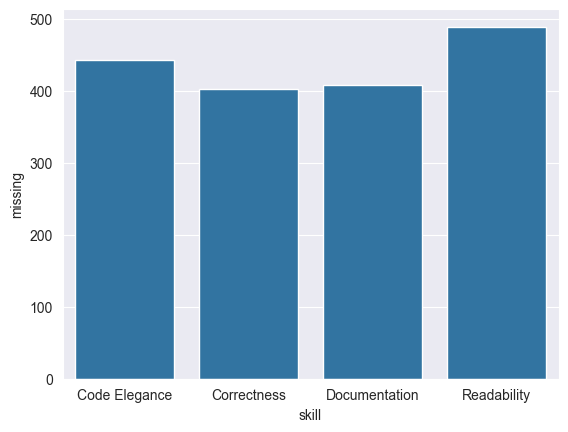

In [44]:
# Maybe add a plot of count of missing at each grade?
sns.barplot(count_df, x='skill', y='missing')

### NLP Techniques

In [45]:
nlp_df = feedback_df[~feedback_df['comments'].isna()].copy()
nlp_df

,assignment_number,comments,skill,participant_id,batch,grade
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-
...,...,...,...,...,...,...
11,525.0,the implementation is good but not distinguish...,Correctness,14,1,A
19,334.0,Not compiling to be specific MusicPlayer.java,Correctness,14,1,D-
4,587.0,some comments are redundant or state the obvio...,Code Elegance,14,1,A-
7,47.0,"Some methods lack detailed comments, making it...",Documentation,14,1,A++


In [46]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords += ['readability', 'correctness', 'documentation', 'maintainability', 'student']

### Sentiment

In [47]:
sia = SentimentIntensityAnalyzer()

def is_positive(comment):
    return sia.polarity_scores(comment)['compound'] > 0

nlp_df['sentiment'] = nlp_df['comments'].apply(is_positive)
nlp_df

,assignment_number,comments,skill,participant_id,batch,grade,sentiment
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+,True
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+,True
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-,True
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-,True
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-,True
...,...,...,...,...,...,...,...
11,525.0,the implementation is good but not distinguish...,Correctness,14,1,A,False
19,334.0,Not compiling to be specific MusicPlayer.java,Correctness,14,1,D-,False
4,587.0,some comments are redundant or state the obvio...,Code Elegance,14,1,A-,True
7,47.0,"Some methods lack detailed comments, making it...",Documentation,14,1,A++,True


In [48]:
sentiment_df = nlp_df[['skill', 'sentiment', 'assignment_number']].groupby(['skill', 'sentiment']).count().reset_index()
sentiment_df.columns = ['skill', 'sentiment', 'count']
sentiment_df['sentiment'] = sentiment_df['sentiment'].apply(lambda x: 'Positive' if x else 'Negative')
sentiment_df

,skill,sentiment,count
0,Code Elegance,Negative,221
1,Code Elegance,Positive,456
2,Correctness,Negative,261
3,Correctness,Positive,453
4,Documentation,Negative,250
5,Documentation,Positive,460
6,Readability,Negative,152
7,Readability,Positive,479


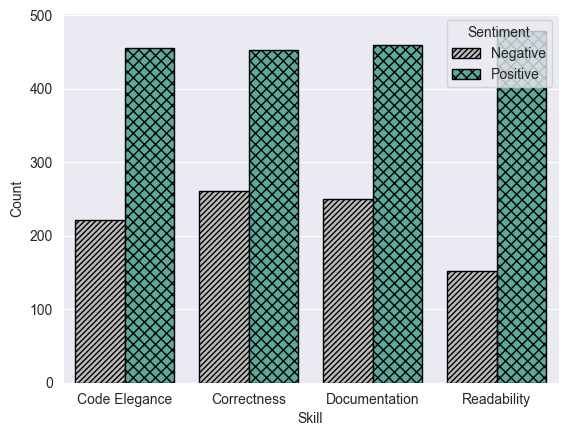

In [49]:
g = sns.barplot(sentiment_df, x='skill', y='count', hue='sentiment')


hatches = ['//', 'x',]
colors = [grey, teal]
styles = zip(hatches, colors)


for style, these_bars in zip(styles, g.containers):
    for this_bar in these_bars:
        this_bar.set_hatch(3 * style[0])
        this_bar.set_facecolor(style[1])
        this_bar.set_edgecolor('black')

g.set(xlabel='Skill', ylabel='Count')
handles = g.get_legend_handles_labels()[0]

for i in range(len(handles)):
    handles[i].set_facecolor(colors[i])
    handles[i].set_hatch(3 * hatches[i])
    handles[i].set_edgecolor('black')

g.legend(title='Sentiment')
g.get_figure().savefig('../plots/sentiment.pdf', bbox_inches='tight')

### LDA Topic Analysis
https://link.springer.com/article/10.1007/s44217-023-00051-0
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9260886/

Code adapted from: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#4.-Build-the-Bigram,-Trigram-Models-and-Lemmatize

In [50]:
# TODO: Build LDA for correctness, readability and maintainability
# TODO: Add plots for dominant topic per document
# TODO: Add plots for word counts of topic key words

In [51]:
def process_words(texts, bigram_mod, trigram_mod, stop_words=stopwords, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'], stem=False):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        
    if stem:
        stemmer = SnowballStemmer('english')
        texts_out = [[stemmer.stem(word) for word in doc] for doc in texts_out]
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]

    return texts_out

In [52]:
def get_data(skill):
    text_data = nlp_df[nlp_df['skill'] == skill]['comments']
    bigram = Phrases(text_data, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = Phrases(bigram[text_data], threshold=100)
    bigram_mod = Phraser(bigram)
    trigram_mod = Phraser(trigram)

    processed_text = process_words(text_data, bigram_mod, trigram_mod, stem=False, allowed_postags=['NOUN'])
    dictionary = corpora.Dictionary(processed_text)
    dictionary.filter_extremes(no_below=15, no_above=0.3, keep_n=10000)
    corpus = [dictionary.doc2bow(text) for text in processed_text]

    model = TfidfModel(corpus)
    tfidf_corpus = [model[i] for i in corpus]
    
    return tfidf_corpus, dictionary, processed_text
    

In [53]:
def generate_topic_model(corpus, dictionary, processed_text, num_topics=5):
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, update_every=1, chunksize=10, passes=15)
    cm = CoherenceModel(model=lda_model, texts=processed_text, coherence='u_mass')
    coherence = cm.get_coherence()
    return lda_model, coherence


In [65]:
def generate_topic_models(tfidf_corpus, dictionary, processed_text):
    models = {}
    coherence_results = []
    
    for topic_count in tqdm([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 100]):
        model, coherence = generate_topic_model(tfidf_corpus, dictionary, processed_text, topic_count)
        models[topic_count] = model
        coherence_results.append({'topic_count':topic_count, 'coherence': coherence})
        
    return models, pd.DataFrame(coherence_results)
    

In [66]:
def run_lda(skill):
    tfidf_corpus, dictionary, processed_text = get_data(skill)
    models, coherence_df= generate_topic_models(tfidf_corpus, dictionary, processed_text)
    print(coherence_df)

    g = sns.lineplot(coherence_df, x='topic_count', y='coherence')
    g.set(title=skill)
    return models, tfidf_corpus

#### Plots

In [73]:
def run_pyLDAvis(models, topic_count):
    return pyLDAvis.gensim.prepare(models[topic_count], corpus, dictionary=models[topic_count].id2word)

In [91]:
def generate_word_cloud(models, topic_count, topic_names=None):
    if topic_names is not None:
        if len(topic_names) < topic_count:
            print('Not enough topic names to generate word cloud')
            return None
        elif len(topic_names) > topic_count:
            print('Too many topic names to generate word cloud')
            return None
        
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

    cloud = WordCloud(stopwords=stopwords,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=15,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    
    topics = models[topic_count].show_topics(formatted=False, num_words=5)
    
    fig, axes = plt.subplots((int(topic_count) // 2) + int(topic_count) % 2, 2, figsize=(10,10), sharex=True, sharey=True)
    
    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        if topic_names is None:
            plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        else:
            plt.gca().set_title('Topic: ' + topic_names[i], fontdict=dict(size=16))
        plt.gca().axis('off')
    
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

### Correctness

100%|██████████| 15/15 [00:06<00:00,  2.40it/s]

    topic_count  coherence
0             1  -6.268296
1             2  -6.566918
2             3  -8.054893
3             4  -7.547131
4             5  -6.372255
5             6  -6.977656
6             7  -6.668391
7             8  -5.705800
8             9  -6.320852
9            10  -5.459307
10           20 -11.468219
11           30 -11.522915
12           40 -11.494910
13           50 -11.452341
14          100 -11.566047


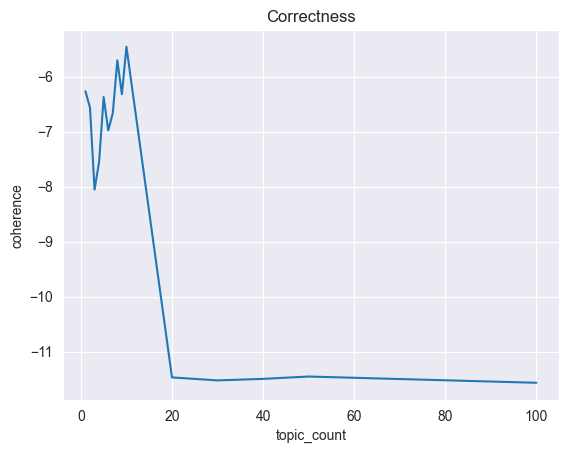

In [105]:
models, corpus = run_lda('Correctness')

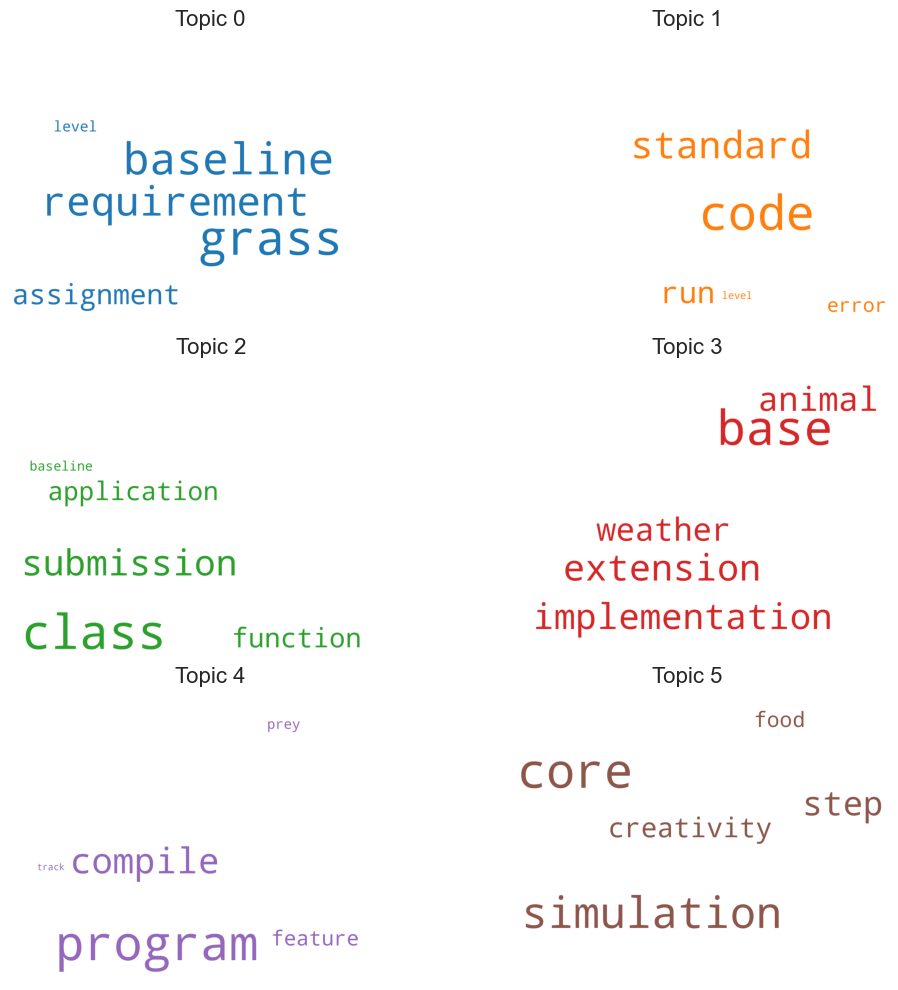

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.130639  0.090143       1        1  40.826839
5      0.052078 -0.301061       2        1  17.080390
2      0.076477 -0.073320       3        1  11.968393
0      0.076129 -0.031549       4        1  10.228662
1     -0.411238  0.024759       5        1  10.070547
4      0.075914  0.291029       6        1   9.825169, topic_info=         Term       Freq      Total Category  logprob  loglift
48    program  67.000000  67.000000  Default  30.0000  30.0000
28      class  65.000000  65.000000  Default  29.0000  29.0000
1        code  56.000000  56.000000  Default  28.0000  28.0000
2        core  63.000000  63.000000  Default  27.0000  27.0000
30      grass  38.000000  38.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
49       step   0.160072  28.773957   Topic6  -6.5592  -2.8714
40   standard   0.159660  32.142574   Topic6  -6.5618  -2.9847
28      class   0.159491  65.528245   Topic6  -6.5628  -3.6980
22       base   0.159373  83.504394   Topic6  -6.5636  -3.9412
39  behaviour   0.159308  27.580363   Topic6  -6.5640  -2.8338

[282 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
15        1  0.910247        addition
21        1  0.984064          animal
31        3  0.910715     application
42        2  0.802250        approach
43        2  0.838228        aptitude
23        4  0.920693      assignment
22        1  0.981984            base
38        4  0.975644        baseline
0         1  0.821167        behavior
39        1  0.978957       behaviour
28        3  0.991939           class
1         5  0.979484            code
36        6  0.952765         compile
2         2  0.987010            core
44        2  0.933496      creativity
3         1  0.887552             day
24        1  0.948139         disease
16        1  0.822029          effect
35        5  0.852957           error
25        1  0.981316       extension
45        6  0.766908         feature
7         1  0.870464          female
8         2  0.948175            food
26        1  0.888529             fox
34        3  0.955634        function
17        1  0.946447          gender
30        4  0.986941           grass
18        1  0.982808  implementation
32        2  0.835529           issue
37        1  0.825745           level
9         1  0.794498            male
4         1  0.810926           night
20        1  0.968906           plant
5         1  0.837583        predator
29        6  0.709535            prey
48        6  0.978455         program
27        1  0.876197          rabbit
6         4  0.962684     requirement
41        5  0.959631             run
10        2  0.976423      simulation
11        2  0.845251          source
12        1  0.975085          specie
40        5  0.964453        standard
49        2  0.973102            step
33        3  0.981334      submission
13        1  0.934580            time
47        6  0.621839           track
19        1  0.982411         weather
14        1  0.957032            work, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 3, 1, 2, 5])

In [110]:
TOPIC_COUNT = 6
generate_word_cloud(models, TOPIC_COUNT)
run_pyLDAvis(models, TOPIC_COUNT)

### Code Elegance

  0%|          | 0/15 [00:00<?, ?it/s]/Users/marcus/workspace/Programming/Consistency_In_Grading_Analysis/venv3.10/lib/python3.10/site-packages/gensim/models/ldamodel.py:847: RuntimeWarning: divide by zero encountered in scalar divide
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)
 93%|█████████▎| 14/15 [00:05<00:00,  2.32it/s]/Users/marcus/workspace/Programming/Consistency_In_Grading_Analysis/venv3.10/lib/python3.10/site-packages/gensim/models/ldamodel.py:847: RuntimeWarning: invalid value encountered in scalar divide
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)
100%|██████████| 15/15 [00:05<00:00,  2.54it/s]

    topic_count  coherence
0             1  -8.545925
1             2 -10.200858
2             3  -7.724823
3             4  -8.340910
4             5  -7.748631
5             6  -6.977525
6             7  -7.748790
7             8  -7.907993
8             9  -7.031816
9            10  -6.611775
10           20 -14.014575
11           30 -14.701594
12           40 -15.002853
13           50 -15.004269
14          100 -15.114455


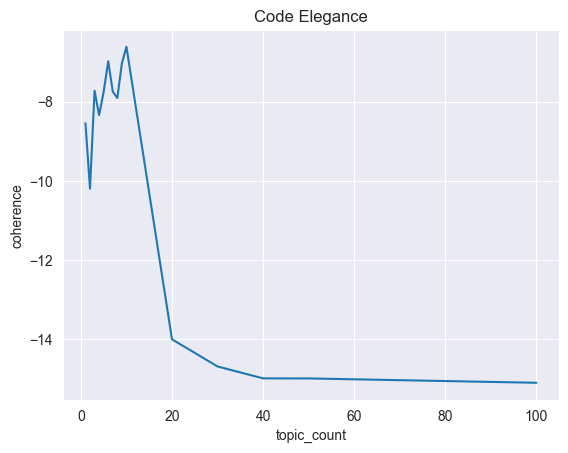

In [115]:
models, corpus = run_lda('Code Elegance')

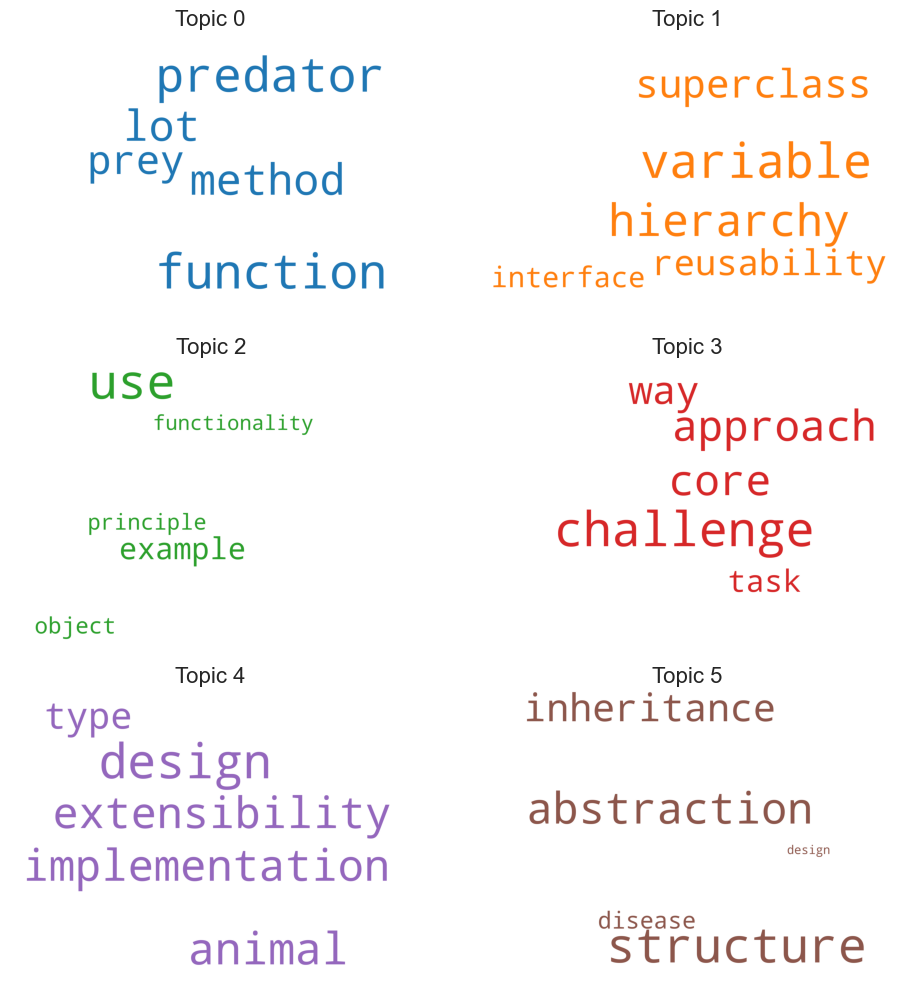

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.291650  0.001306       1        1  21.375628
4     -0.270246 -0.000333       2        1  17.886197
2      0.108740 -0.000120       3        1  16.251810
1      0.166581  0.314757       4        1  15.932957
3      0.164437 -0.321049       5        1  15.707150
5      0.122137  0.005438       6        1  12.846258, topic_info=           Term       Freq      Total Category  logprob  loglift
10          use  91.000000  91.000000  Default  30.0000  30.0000
19    structure  46.000000  46.000000  Default  29.0000  29.0000
16  abstraction  37.000000  37.000000  Default  28.0000  28.0000
38     variable  35.000000  35.000000  Default  27.0000  27.0000
31    challenge  34.000000  34.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
6        method   0.164537  30.134615   Topic6  -6.6053  -3.1582
8      predator   0.164833  37.151898   Topic6  -6.6035  -3.3657
3        animal   0.164554  50.174932   Topic6  -6.6052  -3.6679
10          use   0.164547  91.357051   Topic6  -6.6053  -4.2672
24     function   0.164010  37.896223   Topic6  -6.6085  -3.3906

[262 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
16        6  0.972474     abstraction
25        1  0.900539             act
3         1  0.418536          animal
3         2  0.577978          animal
17        5  0.972892        approach
4         5  0.920033            base
11        2  0.950335        behavior
31        5  0.982658       challenge
35        5  0.865160         concept
40        5  0.967252            core
0         2  0.976040          design
20        6  0.864373         disease
15        3  0.971551         example
36        2  0.958568   extensibility
24        1  0.976351        function
12        3  0.896069   functionality
41        4  0.973444       hierarchy
39        2  0.981539  implementation
5         6  0.987676     inheritance
21        4  0.919427       interface
1         2  0.940161           logic
28        1  0.973568             lot
6         1  0.962348          method
2         4  0.905610      modularity
13        3  0.909974          object
7         2  0.916748           plant
8         1  0.968995        predator
14        1  0.982610            prey
23        3  0.965607       principle
27        1  0.960924      repetition
29        4  0.936729     reusability
34        5  0.895844         segment
18        2  0.705788          specie
19        6  0.977921       structure
26        2  0.574317        subclass
30        4  0.972250      superclass
32        5  0.919127            task
37        4  0.947917            time
9         2  0.953185            type
10        3  0.996092             use
38        4  0.973688        variable
33        5  0.983682             way
22        4  0.969788         weather, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 2, 4, 6])

In [116]:
TOPIC_COUNT = 6
generate_word_cloud(models, TOPIC_COUNT)
run_pyLDAvis(models, TOPIC_COUNT)

### Readability

100%|██████████| 15/15 [00:04<00:00,  3.14it/s]

    topic_count  coherence
0             1  -9.973276
1             2 -11.021087
2             3 -10.291943
3             4  -9.616342
4             5  -9.400095
5             6 -10.160412
6             7  -9.310493
7             8  -9.837167
8             9  -9.744100
9            10 -10.077557
10           20 -12.246489
11           30 -11.947619
12           40 -11.913439
13           50 -11.892017
14          100 -11.901901


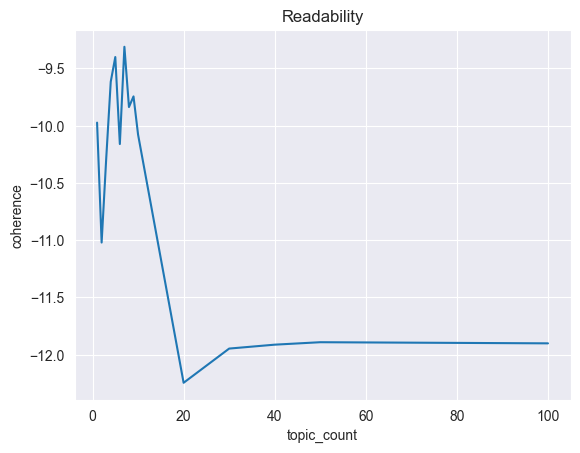

In [67]:
models, corpus = run_lda('Readability')

IndexError: list index out of range

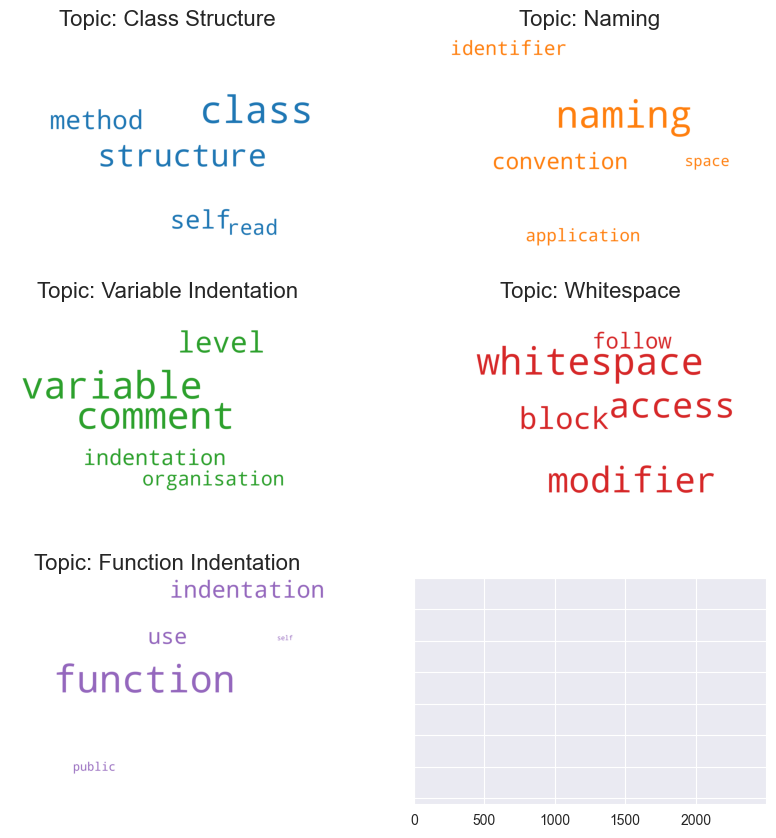

In [104]:
TOPIC_COUNT = 5
generate_word_cloud(models, TOPIC_COUNT, topic_names=['Class Structure', 'Naming', 'Variable Indentation', 'Whitespace', 'Function Indentation'])
run_pyLDAvis(models, TOPIC_COUNT)

### Documentation

100%|██████████| 15/15 [00:06<00:00,  2.44it/s]

    topic_count  coherence
0             1 -11.391351
1             2 -14.217742
2             3 -12.876679
3             4 -12.517950
4             5 -13.016661
5             6 -11.628547
6             7 -12.111127
7             8 -11.975183
8             9 -11.963671
9            10 -11.840679
10           20 -16.261704
11           30 -16.733714
12           40 -16.721385
13           50 -16.747480
14          100 -16.790174


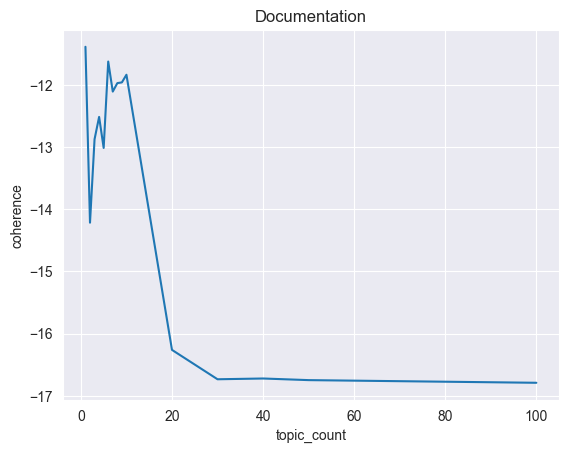

In [117]:
models, corpus = run_lda('Documentation')

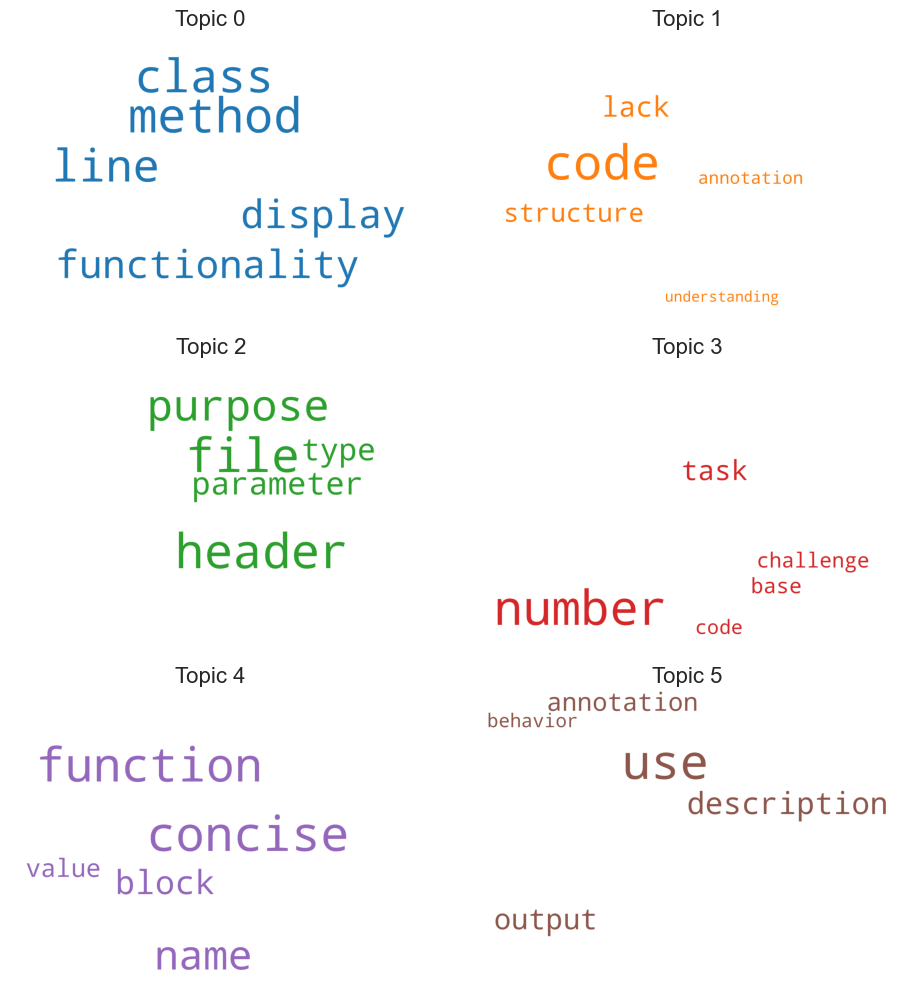

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.082558 -0.270928       1        1  21.613637
5     -0.161354 -0.133633       2        1  16.976585
2      0.148134 -0.094776       3        1  16.659870
1     -0.163862  0.212323       4        1  15.108274
4      0.342708  0.067509       5        1  14.999065
3     -0.083069  0.219505       6        1  14.642568, topic_info=        Term       Freq      Total Category  logprob  loglift
8       code  88.000000  88.000000  Default  30.0000  30.0000
30    number  67.000000  67.000000  Default  29.0000  29.0000
18       use  72.000000  72.000000  Default  28.0000  28.0000
23   concise  36.000000  36.000000  Default  27.0000  27.0000
22  function  34.000000  34.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
2     header   0.375659  35.712257   Topic6  -5.7749  -2.6333
4     method   0.373151  35.824568   Topic6  -5.7816  -2.6432
23   concise   0.373005  36.483462   Topic6  -5.7820  -2.6618
18       use   0.373004  72.536874   Topic6  -5.7820  -3.3490
22  function   0.372950  34.926725   Topic6  -5.7822  -2.6183

[251 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
16        1  0.429192      annotation
16        2  0.398536      annotation
16        3  0.030657      annotation
16        4  0.122626      annotation
16        5  0.030657      annotation
16        6  0.030657      annotation
25        1  0.915344        argument
28        6  0.822248            base
14        2  0.802395        behavior
7         5  0.908335           block
32        6  0.844374       challenge
0         1  0.970918           class
8         4  0.937339            code
8         6  0.056466            code
35        6  0.739334           color
23        5  0.959339         concise
15        2  0.934403     description
27        1  0.966946         display
29        6  0.512565     elaboration
1         3  0.961699            file
22        5  0.973467        function
9         1  0.950329   functionality
2         3  0.980056          header
11        4  0.910900            lack
3         1  0.960263            line
4         1  0.976983          method
26        5  0.961254            name
30        6  0.986849          number
17        2  0.941480          output
5         3  0.934281       parameter
6         3  0.973112         purpose
36        6  0.739334  representation
20        3  0.943694          return
21        2  0.806931            role
33        6  0.784876       simulator
13        4  0.919470       structure
31        6  0.490025          system
19        6  0.936695            task
24        1  0.305307            type
24        3  0.523383            type
24        4  0.043615            type
24        5  0.087231            type
12        4  0.771235   understanding
18        2  0.978813             use
10        5  0.880081           value
34        6  0.779093            view, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 3, 2, 5, 4])

In [119]:
TOPIC_COUNT = 6
generate_word_cloud(models, TOPIC_COUNT)
run_pyLDAvis(models, TOPIC_COUNT)